In [64]:
import os
from openai import OpenAI

api_key = os.getenv("OPENAI_API_KEY")  # Environment variable: "OPENAI_API_KEY"
print("API KEY FROM ENV:", api_key is not None)  # True: success!

client = OpenAI(api_key=api_key)

# client = OpenAI(api_key=API_key)

API KEY FROM ENV: True


In [76]:
import torch
import numpy as np
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load the reference solution data
dataset_path = "/kaggle/input/pinn-dataset/"
file_name = "Burgers.npz"

file_path = os.path.join(dataset_path, file_name)

print(os.listdir(dataset_path))


data = np.load(file_path)
t_ref, x_ref, exact = data["t"], data["x"], data["usol"].T

# Reshape x_ref and t_ref to match the shape of exact
x_ref, t_ref = np.meshgrid(x_ref, t_ref)

# Prepare the data
X_ref = np.vstack((np.ravel(x_ref), np.ravel(t_ref))).T
Y_ref = exact.flatten()[:, None]

# Convert to tensor
X_ref_torch = torch.tensor(X_ref, dtype=torch.float32, device=device)
Y_ref_torch = torch.tensor(Y_ref, dtype=torch.float32, device=device)

print("X_ref_torch:", X_ref_torch.shape)
print("Y_ref_torch:", Y_ref_torch.shape)


Using device: cpu
['NLS.mat', 'Burgers.npz']
X_ref_torch: torch.Size([25600, 2])
Y_ref_torch: torch.Size([25600, 1])


In [77]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ============================================================
# 0. LLM prompt was set earlier: use the same prompt function
# ============================================================

# ============================================================
# 1. Problem setup (PDE + domain + IC/BC)
# ============================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Viscosity for Burgers-type PDE
nu = 0.01 / np.pi

# Domain ranges
x_min, x_max = -1.0, 1.0
t_min, t_max = 0.0, 1.0


def initial_condition(x):
    """
    Initial condition:
        u(x, 0) = -sin(pi * x)
    x: tensor of shape (N, 1) containing spatial coordinates
    """
    return -torch.sin(np.pi * x)


def boundary_condition(x, t):
    """
    Dirichlet boundary condition at x = -1 and x = 1:
        u(-1, t) = 0
        u( 1, t) = 0
    x, t are tensors of shape (N, 1). We only need x here.
    """
    return torch.zeros_like(x)


# ============================================================
# 2. PINN model definition
# ============================================================

class PINN(nn.Module):
    """
    Simple fully-connected neural network for u(x, t).
    Input:  (x, t) ∈ R^2
    Output: u(x, t) ∈ R
    """

    def __init__(self, input_dim=2, hidden_dim=20, num_hidden_layers=3, output_dim=1):
        super().__init__()

        layers = []
        in_dim = input_dim

        # Hidden layers
        for _ in range(num_hidden_layers):
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(nn.Tanh())
            in_dim = hidden_dim

        # Final layer (no activation)
        layers.append(nn.Linear(in_dim, output_dim))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass: x is of shape (N, 2) = [x, t].
        Returns: u(x, t) of shape (N, 1).
        """
        return self.net(x)


# ============================================================
# 3. Sampling training points for PDE / BC / IC
# ============================================================

def sample_interior_points(N_int):
    """
    Sample N_int interior points (x, t) in the domain (excluding boundaries)
        x ∈ (x_min, x_max)
        t ∈ (t_min, t_max)
    """
    x = np.random.uniform(x_min, x_max, (N_int, 1))
    t = np.random.uniform(t_min, t_max, (N_int, 1))
    X_int = np.hstack((x, t))
    return torch.tensor(X_int, dtype=torch.float32, device=device)


def sample_boundary_points(N_bc):
    """
    Sample N_bc boundary points on x = -1 and x = 1 for all times t ∈ [t_min, t_max].
    We choose half of them at x=-1, half at x=1.
    """
    # Half at x = -1
    t_left = np.random.uniform(t_min, t_max, (N_bc // 2, 1))
    x_left = -np.ones_like(t_left)

    # Half at x =  1
    t_right = np.random.uniform(t_min, t_max, (N_bc - N_bc // 2, 1))
    x_right = np.ones_like(t_right)

    x_bc = np.vstack((x_left, x_right))
    t_bc = np.vstack((t_left, t_right))

    X_bc = np.hstack((x_bc, t_bc))
    return torch.tensor(X_bc, dtype=torch.float32, device=device)


def sample_initial_points(N_ic):
    """
    Sample N_ic points at initial time t = 0 with x ∈ [x_min, x_max].
    """
    x = np.random.uniform(x_min, x_max, (N_ic, 1))
    t = np.zeros_like(x)
    X_ic = np.hstack((x, t))
    return torch.tensor(X_ic, dtype=torch.float32, device=device)


# ============================================================
# 4. PDE residual computation using autograd
# ============================================================

def pde_residual(model, X_int):
    """
    Compute the PDE residual at interior points X_int.

    PDE:
        u_t + u * u_x - nu * u_xx = 0

    Steps:
      - X_int has shape (N, 2): columns [x, t]
      - Enable autograd on X_int
      - Compute u(x, t)
      - Use torch.autograd.grad to get u_x, u_t, u_xx
      - Form the residual f = u_t + u*u_x - nu*u_xx
    """
    X_int.requires_grad_(True)

    # Forward pass: u(x, t)
    u = model(X_int)  # (N, 1)

    # First derivatives wrt (x, t)
    grads = torch.autograd.grad(
        u,
        X_int,
        grad_outputs=torch.ones_like(u),
        create_graph=True,
        retain_graph=True,
    )[0]  # shape (N, 2)

    u_x = grads[:, 0:1]  # ∂u/∂x
    u_t = grads[:, 1:1+1]  # ∂u/∂t

    # Second derivative u_xx = ∂²u/∂x²
    grads_x = torch.autograd.grad(
        u_x,
        X_int,
        grad_outputs=torch.ones_like(u_x),
        create_graph=True,
        retain_graph=True,
    )[0]
    u_xx = grads_x[:, 0:1]

    # PDE residual
    f = u_t + u * u_x - nu * u_xx
    return f


# ============================================================
# 5. Loss functions for PDE / BC / IC
# ============================================================

mse_loss = nn.MSELoss()


def compute_losses(model, N_int, N_bc, N_ic):
    """
    Sample fresh points and compute:
      - PDE loss (interior)
      - BC loss (Dirichlet at x=-1,1)
      - IC loss (initial condition at t=0)

    Returns:
      total_loss, loss_pde, loss_bc, loss_ic
    """

    # ---------- Interior (PDE) points ----------
    X_int = sample_interior_points(N_int)  # (N_int, 2)
    f = pde_residual(model, X_int)
    loss_pde = mse_loss(f, torch.zeros_like(f))

    # ---------- Boundary points ----------
    X_bc = sample_boundary_points(N_bc)  # (N_bc, 2)
    x_bc = X_bc[:, 0:1]
    t_bc = X_bc[:, 1:2]
    u_bc_pred = model(X_bc)
    u_bc_true = boundary_condition(x_bc, t_bc)
    loss_bc = mse_loss(u_bc_pred, u_bc_true)

    # ---------- Initial points ----------
    X_ic = sample_initial_points(N_ic)  # (N_ic, 2)
    x_ic = X_ic[:, 0:1]
    u_ic_pred = model(X_ic)
    u_ic_true = initial_condition(x_ic)
    loss_ic = mse_loss(u_ic_pred, u_ic_true)

    # Total loss (you can also add weights here if desired)
    total_loss = loss_pde + loss_bc + loss_ic

    return total_loss, loss_pde.detach(), loss_bc.detach(), loss_ic.detach()




def l2_relative_error(y_true, y_pred):
    """
    Compute L2 relative error:
        ||y_pred - y_true||_2 / ||y_true||_2
    """
    num = torch.linalg.norm(y_pred - y_true)
    den = torch.linalg.norm(y_true) + 1e-12
    return (num / den).item()


def evaluate_model_l2(model):
    """
    Evaluate the model on the reference grid from Burgers.npz
    using (X_ref_torch, Y_ref_torch).
    """
    model.eval()
    with torch.no_grad():
        u_pred = model(X_ref_torch)       # shape (N_ref, 1)
    return l2_relative_error(Y_ref_torch, u_pred)


# ============================================================
# 7. One training phase (fixed LR and epochs)
# ============================================================

def train_one_phase(model, optimizer, N_int, N_bc, N_ic, epochs):
    """
    Train the given model for a fixed number of epochs with the given optimizer.

    Returns:
      - loss_list: list of total loss values over epochs
    """
    loss_list = []

    for epoch in range(1, epochs + 1):
        optimizer.zero_grad()
        total_loss, loss_pde, loss_bc, loss_ic = compute_losses(
            model, N_int, N_bc, N_ic
        )
        total_loss.backward()
        optimizer.step()

        loss_list.append(total_loss.item())

        if epoch % max(epochs // 10, 1) == 0:
            print(
                f"  Epoch {epoch:5d} | "
                f"Total: {total_loss.item():.3e} | "
                f"PDE: {loss_pde.item():.3e} | "
                f"BC: {loss_bc.item():.3e} | "
                f"IC: {loss_ic.item():.3e}"
            )

    return loss_list



Using device: cpu


In [100]:
###----------------------------------------------------------------------
###  Prompt function 1

def query_llm_for_hyperparams(current_lr, loss_list, prev_epochs, l2_error, prev_l2_errors, best_error, phase_num):
    """
    Ask an LLM to suggest a new (learning_rate, epochs) based on:
      - current LR and number of epochs
      - recent training loss trend
      - L2 error in this phase
      - history of L2 errors
      - best L2 so far
    """
    
    trend = ", ".join([f"{l:.2e}" for l in loss_list])
    l2_trend = ", ".join([f"{e:.2e}" for e in prev_l2_errors]) if prev_l2_errors else "N/A"

    # Prompt contains the following: (1) Context, (2) Output format, (3) Decision rule    
    prompt = f"""
You are optimizing a Physics-Informed Neural Network (PINN) solving a nonlinear PDE.

Phase {phase_num}:
- Previous LR: {current_lr:.1e}, Epochs: {prev_epochs}
- Loss trend: {trend}
- L2 error this phase: {l2_error:.2e}
- L2 error history: {l2_trend}
- Best L2 error so far: {best_error:.2e}

Suggest new values:
learning_rate: <value>
epochs: <value>

Guidelines:
- Reduce LR if loss is noisy or L2 worsens
- Increase epochs if LR is reduced
- Continue if loss is improving
- Avoid frequent LR changes
- Stop if L2 error < 0.035
"""

    response = client.chat.completions.create(
        model="gpt-5-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=1   # GPT-5-mini has only temperature =1 as a default
    )
    # temperature = 0:  getting deterministic responses
    
    reply = response.choices[0].message.content.strip().lower()
    new_lr, new_epochs = current_lr, prev_epochs
    for line in reply.splitlines():
        if "learning_rate" in line:
            val = line.split(":")[1].strip()
            try: new_lr = float(val)
            except: pass
        elif "epochs" in line:
            try: new_epochs = int(line.split(":")[1].strip())
            except: pass
                
    return max(min(new_lr, 1e-2), 1e-5), max(new_epochs, 1000)




# # ###----------------------------------------------------------------------
# # ###  Prompt function 2

# def query_llm_for_hyperparams(
#     current_lr,
#     loss_list,
#     prev_epochs,
#     l2_error,
#     prev_l2_errors,
#     best_error,
#     phase_num,
# ):
#     """
#     Ask LLM for new (learning_rate, epochs) using a compact, trend-aware prompt.
#     The prompt is short but still encodes:
#       - loss trend within this phase
#       - L2 trend across phases
#       - current / best L2
#     """

#     # --- 1) In-phase loss trend ---
#     loss_first = loss_list[0]
#     loss_last = loss_list[-1]
#     loss_ratio = loss_last / loss_first if loss_first != 0 else 1.0

#     if loss_ratio < 0.7:
#         loss_trend_label = "strong_down"
#     elif loss_ratio < 0.95:
#         loss_trend_label = "mild_down"
#     elif loss_ratio < 1.05:
#         loss_trend_label = "flat"
#     else:
#         loss_trend_label = "up"

#     # --- 2) Cross-phase L2 trend ---
#     l2_curr = l2_error
#     l2_prev = prev_l2_errors[-1] if prev_l2_errors else l2_curr
#     l2_delta = l2_curr - l2_prev

#     if l2_delta < -1e-3:
#         l2_trend_label = "improving"
#     elif l2_delta > 1e-3:
#         l2_trend_label = "worsening"
#     else:
#         l2_trend_label = "flat"

#     # --- 3) Short, structured prompt ---
#     # Note: we drop phases_since_best, avg_l2_last3 to keep it shorter.
#     prompt = (
#         "PINN LR/epoch tuning.\n"
#         f"phase={phase_num}\n"
#         f"lr_prev={current_lr:.2e}\n"
#         f"epochs_prev={prev_epochs}\n"
#         f"loss_ratio={loss_ratio:.2e}\n"
#         f"loss_trend={loss_trend_label}\n"
#         f"l2_curr={l2_curr:.2e}\n"
#         f"l2_prev={l2_prev:.2e}\n"
#         f"l2_trend={l2_trend_label}\n"
#         f"l2_best={best_error:.2e}\n"
#         "rules:\n"
#         "- if l2_trend=worsening or loss_trend in [flat,up]: decrease lr and increase epochs.\n"
#         "- if l2_trend=improving and l2_curr>0.1: slightly adjust (small change in lr or epochs).\n"
#         "- if l2_curr<0.035 you may keep lr and epochs.\n"
#         "- always keep 1e-5 <= lr <= 1e-2, epochs>=1000.\n"
#         "Output only: <lr> <epochs>\n"
#         "Example: 5e-4 4000"
#     )

#     resp = client.chat.completions.create(
#         model="gpt-5-mini",
#         messages=[
#             {
#                 "role": "system",
#                 "content": "You output exactly two numbers: <lr> <epochs>."
#             },
#             {
#                 "role": "user",
#                 "content": prompt,
#             },
#         ],
#     )

#     reply = resp.choices[0].message.content.strip()

#     # --- 4) Robust numeric parsing (even if format is a bit off) ---
#     tokens = reply.replace(",", " ").split()

#     float_candidates = []
#     int_candidates = []
#     for tok in tokens:
#         try:
#             v = float(tok)
#             float_candidates.append(v)
#         except Exception:
#             pass
#         try:
#             v_int = int(tok)
#             int_candidates.append(v_int)
#         except Exception:
#             pass

#     new_lr = current_lr
#     new_epochs = prev_epochs

#     # First float → lr
#     if len(float_candidates) >= 1:
#         new_lr = float_candidates[0]

#     # First int → epochs
#     if len(int_candidates) >= 1:
#         new_epochs = int_candidates[0]

#     # Safety clipping
#     new_lr = max(min(new_lr, 1e-2), 1e-5)
#     new_epochs = max(new_epochs, 1000)

#     return new_lr, new_epochs



# ###----------------------------------------------------------------------
# ###  Prompt function 3

# def query_llm_for_hyperparams(
#     current_lr,
#     loss_list,
#     prev_epochs,
#     l2_error,
#     prev_l2_errors,
#     best_error,
#     phase_num,
# ):
#     """
#     Ask an LLM to suggest a new (learning_rate, epochs) based on:
#       - current LR and number of epochs
#       - recent training loss trend within this phase
#       - L2 error in this phase
#       - history of L2 errors across phases
#       - best L2 so far
#     The prompt is compact but still trend-aware.
#     """

#     # --- 1) In-phase loss trend (within this phase only) ---
#     loss_first = loss_list[0]                  # loss at the beginning of this phase
#     loss_last = loss_list[-1]                  # loss at the end of this phase
#     loss_ratio = loss_last / loss_first if loss_first != 0 else 1.0  # how much loss changed

#     # Categorize how the loss evolved during the phase
#     if loss_ratio < 0.7:
#         loss_trend_label = "strong_down"       # large improvement
#     elif loss_ratio < 0.95:
#         loss_trend_label = "mild_down"         # moderate improvement
#     elif loss_ratio < 1.05:
#         loss_trend_label = "flat"              # almost no change
#     else:
#         loss_trend_label = "up"                # got worse

#     # --- 2) Cross-phase L2 trend (between phases) ---
#     l2_curr = l2_error                         # L2 error in this phase
#     l2_prev = prev_l2_errors[-1] if prev_l2_errors else l2_curr  # last phase L2 (or same if first)
#     l2_delta = l2_curr - l2_prev               # change in L2 compared to previous phase

#     # Label how L2 error is changing across phases
#     if l2_delta < -1e-3:
#         l2_trend_label = "improving"
#     elif l2_delta > 1e-3:
#         l2_trend_label = "worsening"
#     else:
#         l2_trend_label = "flat"

#     # --- 2-1) Extra summary statistics about phases and L2 history ---
#     phases_done = phase_num
#     if prev_l2_errors:
#         idx_best = int(np.argmin(prev_l2_errors))          # index of best L2 so far
#         phases_since_best = phases_done - 1 - idx_best     # how long since best phase
#         # Average L2 over last 3 phases (or just current if fewer than 3)
#         avg_l2_last3 = float(np.mean(prev_l2_errors[-3:])) \
#                        if len(prev_l2_errors) >= 3 else l2_curr
#     else:
#         phases_since_best = 0
#         avg_l2_last3 = l2_curr

#     # --- 3) Compact, trend-aware prompt for the LLM ---
#     # The prompt encodes all key info in a short, structured format.
#     # IMPORTANT: we explicitly force the model to always change at least
#     # one of (lr, epochs) unless L2 is already very small.
#     prompt = (
#         "PINN hyperparameter tuning.\n"
#         "You must output new training hyperparameters for the NEXT phase.\n"
#         "Do NOT just repeat the previous learning rate and epochs unless l2_curr < 0.035.\n\n"
#         f"phase={phase_num}\n"
#         f"lr_prev={current_lr:.2e}\n"
#         f"epochs_prev={prev_epochs}\n"
#         f"loss_first={loss_first:.2e}\n"
#         f"loss_last={loss_last:.2e}\n"
#         f"loss_ratio={loss_ratio:.2e}\n"
#         f"loss_trend={loss_trend_label}\n"
#         f"l2_curr={l2_curr:.2e}\n"
#         f"l2_prev={l2_prev:.2e}\n"
#         f"l2_trend={l2_trend_label}\n"
#         f"l2_best={best_error:.2e}\n"
#         f"phases_since_best={phases_since_best}\n"
#         f"avg_l2_last3={avg_l2_last3:.2e}\n\n"
#         "Policy:\n"
#         "- If l2_trend=worsening or loss_trend in [flat, up]: "
#         "decrease learning rate and increase epochs.\n"
#         "- If l2_trend=improving but l2_curr is still > 0.1: "
#         "slightly decrease learning rate or slightly increase epochs.\n"
#         "- If l2_curr < 0.035 you may keep LR and epochs unchanged.\n"
#         "- Always keep lr in [1e-5, 1e-2] and epochs >= 1000.\n\n"
#         "Return ONLY one line with two numbers: <lr> <epochs>\n"
#         "Example: 5e-4 4000\n"
#     )

#     # --- 4) Call the LLM with the compact prompt ---
#     resp = client.chat.completions.create(
#         model="gpt-5-mini",
#         messages=[
#             {
#                 "role": "system",
#                 "content": (
#                     "You are a precise numeric assistant. "
#                     "You MUST respond with exactly two numbers: <lr> <epochs>."
#                 ),
#             },
#             {
#                 "role": "user",
#                 "content": prompt,
#             },
#         ],
#         # gpt-5-mini effectively uses its default sampling;
#         # temperature argument is not configurable in the same way as GPT-4.
#     )

#     reply = resp.choices[0].message.content.strip()

#     # --- 5) Robust parsing: extract floats and ints from the reply ---
#     # We do NOT assume the first two tokens are directly "<lr> <epochs>";
#     # instead we scan all tokens and pick:
#     #   - first float  -> lr
#     #   - first int    -> epochs
#     tokens = reply.replace(",", " ").split()

#     # Collect all float-like tokens
#     float_candidates = []
#     for tok in tokens:
#         try:
#             v = float(tok)
#             float_candidates.append(v)
#         except Exception:
#             continue

#     # Collect all int-like tokens
#     int_candidates = []
#     for tok in tokens:
#         try:
#             v = int(tok)
#             int_candidates.append(v)
#         except Exception:
#             continue

#     # Fallback: keep previous values if parsing fails
#     new_lr = current_lr
#     new_epochs = prev_epochs

#     # First float → learning rate
#     if len(float_candidates) >= 1:
#         new_lr = float_candidates[0]

#     # First int → epochs
#     if len(int_candidates) >= 1:
#         new_epochs = int_candidates[0]

#     # --- 6) Safety clipping (min/max boundary) ---
#     new_lr = max(min(new_lr, 1e-2), 1e-5)
#     new_epochs = max(new_epochs, 1000)

#     return new_lr, new_epochs


In [101]:

# ============================================================
# 8. LLM-driven multi-phase training loop
# ============================================================

log = []
l2_errors = []
best_l2_error = 1.0

# Initial hyperparameters for phase 1
current_lr = 1e-1
current_epochs = 2000

# Number of training points per batch (you can tune these)
N_int = 2000   # interior collocation points
N_bc = 100     # boundary points
N_ic = 200     # initial-condition points

max_phases = 20

best_model_state = None

for phase in range(1, max_phases + 1):
    print(f"\n - Phase {phase}: LR = {current_lr}, Epochs = {current_epochs}")

    # Create a fresh model *per phase* (as in your DeepXDE code)
    model = PINN(input_dim=2, hidden_dim=20, num_hidden_layers=3, output_dim=1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=current_lr)

    # Train for current_epochs with current_lr
    loss_list = train_one_phase(
        model, optimizer, N_int=N_int, N_bc=N_bc, N_ic=N_ic, epochs=current_epochs
    )

    # Evaluate L2 error on the reference grid
    l2_error = evaluate_model_l2(model)
    best_l2_error = min(best_l2_error, l2_error)
    l2_errors.append(l2_error)

    print(f"- L2 Error (phase {phase}): {l2_error:.2e}")

    # Store log
    final_loss = loss_list[-1]
    log.append(
        {   "Phase": phase,
            "LR": f"{current_lr:.0e}",
            "Epochs": current_epochs,
            "Final Loss": final_loss,
            "L2 Rel Error": l2_error,
        }
    )

    # Save best model so far
    if l2_error <= best_l2_error + 1e-12:
        best_model_state = model.state_dict()

    # Early stopping condition
    if l2_error < 0.035:
        print(f"- Early stopping at phase {phase}")
        break

    # Ask LLM for next phase hyperparameters
    current_lr, current_epochs = query_llm_for_hyperparams(
        current_lr=current_lr,
        loss_list=loss_list,
        prev_epochs=current_epochs,
        l2_error=l2_error,
        prev_l2_errors=l2_errors,
        best_error=best_l2_error,
        phase_num=phase,
    )



 - Phase 1: LR = 0.1, Epochs = 2000
  Epoch   200 | Total: 7.733e-02 | PDE: 4.228e-02 | BC: 4.808e-03 | IC: 3.024e-02
  Epoch   400 | Total: 1.387e-01 | PDE: 4.619e-02 | BC: 6.582e-04 | IC: 9.184e-02
  Epoch   600 | Total: 9.631e-02 | PDE: 4.153e-02 | BC: 9.373e-04 | IC: 5.385e-02
  Epoch   800 | Total: 1.420e-01 | PDE: 7.096e-02 | BC: 6.540e-03 | IC: 6.448e-02
  Epoch  1000 | Total: 2.196e-01 | PDE: 2.125e-02 | BC: 3.632e-02 | IC: 1.620e-01
  Epoch  1200 | Total: 2.178e-01 | PDE: 1.923e-02 | BC: 2.249e-02 | IC: 1.761e-01
  Epoch  1400 | Total: 3.301e-01 | PDE: 1.571e-02 | BC: 1.045e-01 | IC: 2.099e-01
  Epoch  1600 | Total: 3.256e-01 | PDE: 5.766e-03 | BC: 1.048e-01 | IC: 2.151e-01
  Epoch  1800 | Total: 2.888e-01 | PDE: 2.921e-03 | BC: 9.564e-02 | IC: 1.902e-01
  Epoch  2000 | Total: 5.711e-01 | PDE: 1.586e-06 | BC: 3.045e-02 | IC: 5.406e-01
- L2 Error (phase 1): 1.07e+00

 - Phase 2: LR = 0.001, Epochs = 4000
  Epoch   400 | Total: 1.506e-01 | PDE: 6.152e-02 | BC: 7.447e-03 | IC: 8

KeyboardInterrupt: 

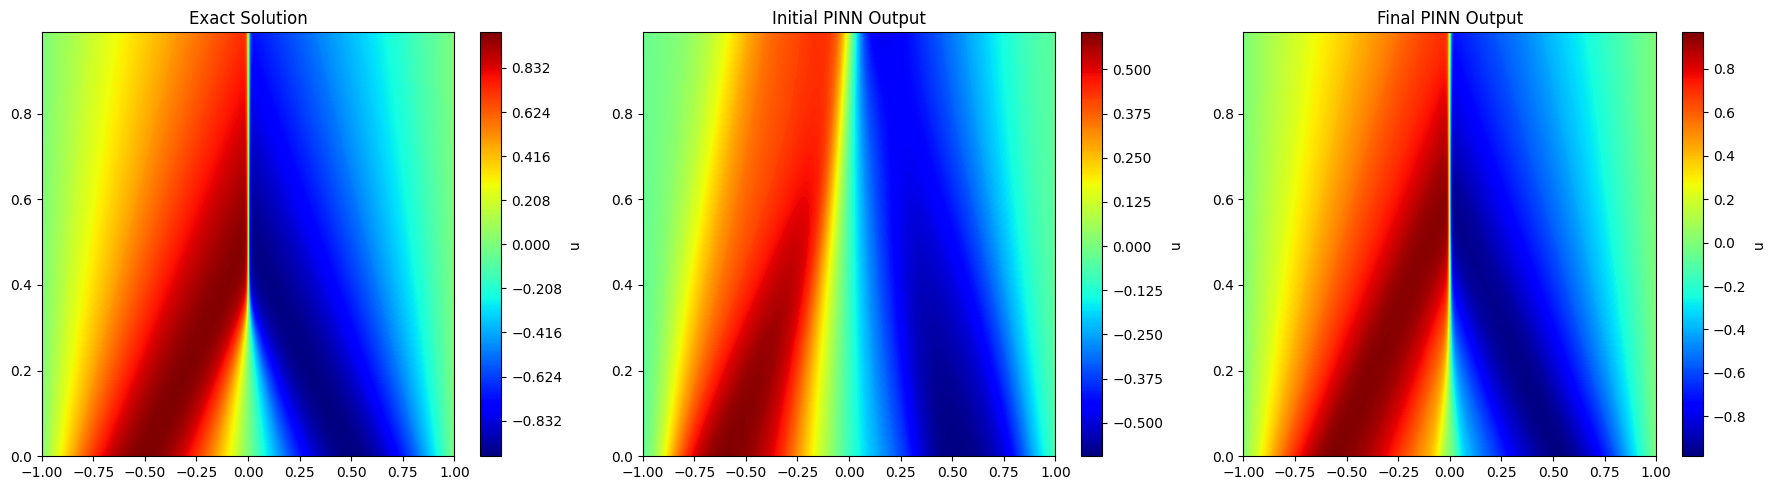

In [81]:
# # Plotting
# plt.figure(figsize=(18, 5))
# plt.subplot(1, 3, 1)
# plt.contourf(x_ref, t_ref, exact, levels=250, cmap="jet")
# plt.colorbar(label="u")
# plt.title("Exact Solution")
# plt.subplot(1, 3, 2)
# plt.contourf(x_ref, t_ref, y_pred_phase1.reshape(exact.shape), levels=250, cmap="jet")
# plt.colorbar(label="u")
# plt.title("Initial PINN Output")
# plt.subplot(1, 3, 3)
# plt.contourf(x_ref, t_ref, y_pred_final.reshape(exact.shape), levels=250, cmap="jet")
# plt.colorbar(label="u")
# plt.title("Final PINN Output")
# plt.tight_layout()
# plt.show()


# Compute min and max
min_exact, max_exact = Y_ref.min(), Y_ref.max()
min_init, max_init = y_pred_phase1.min(), y_pred_phase1.max()
min_final, max_final = y_pred_final.min(), y_pred_final.max()

# Accuracy in percentage form
min_init_pct = (min_init / min_exact) * 100
max_init_pct = (max_init / max_exact) * 100
min_final_pct = (min_final / min_exact) * 100
max_final_pct = (max_final / max_exact) * 100

# Create table
df = pd.DataFrame({
    "Type": ["Exact", "Initial PINN", "Final PINN"],
    "Min Value": [min_exact, min_init, min_final],
    "Max Value": [max_exact, max_init, max_final],
    "Min % of Exact": [100.00, min_init_pct, min_final_pct],
    "Max % of Exact": [100.00, max_init_pct, max_final_pct],
})

# Print the table
print(df.to_string(index=False, float_format="%.5f"))

time_slices =  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
num_steps =  11


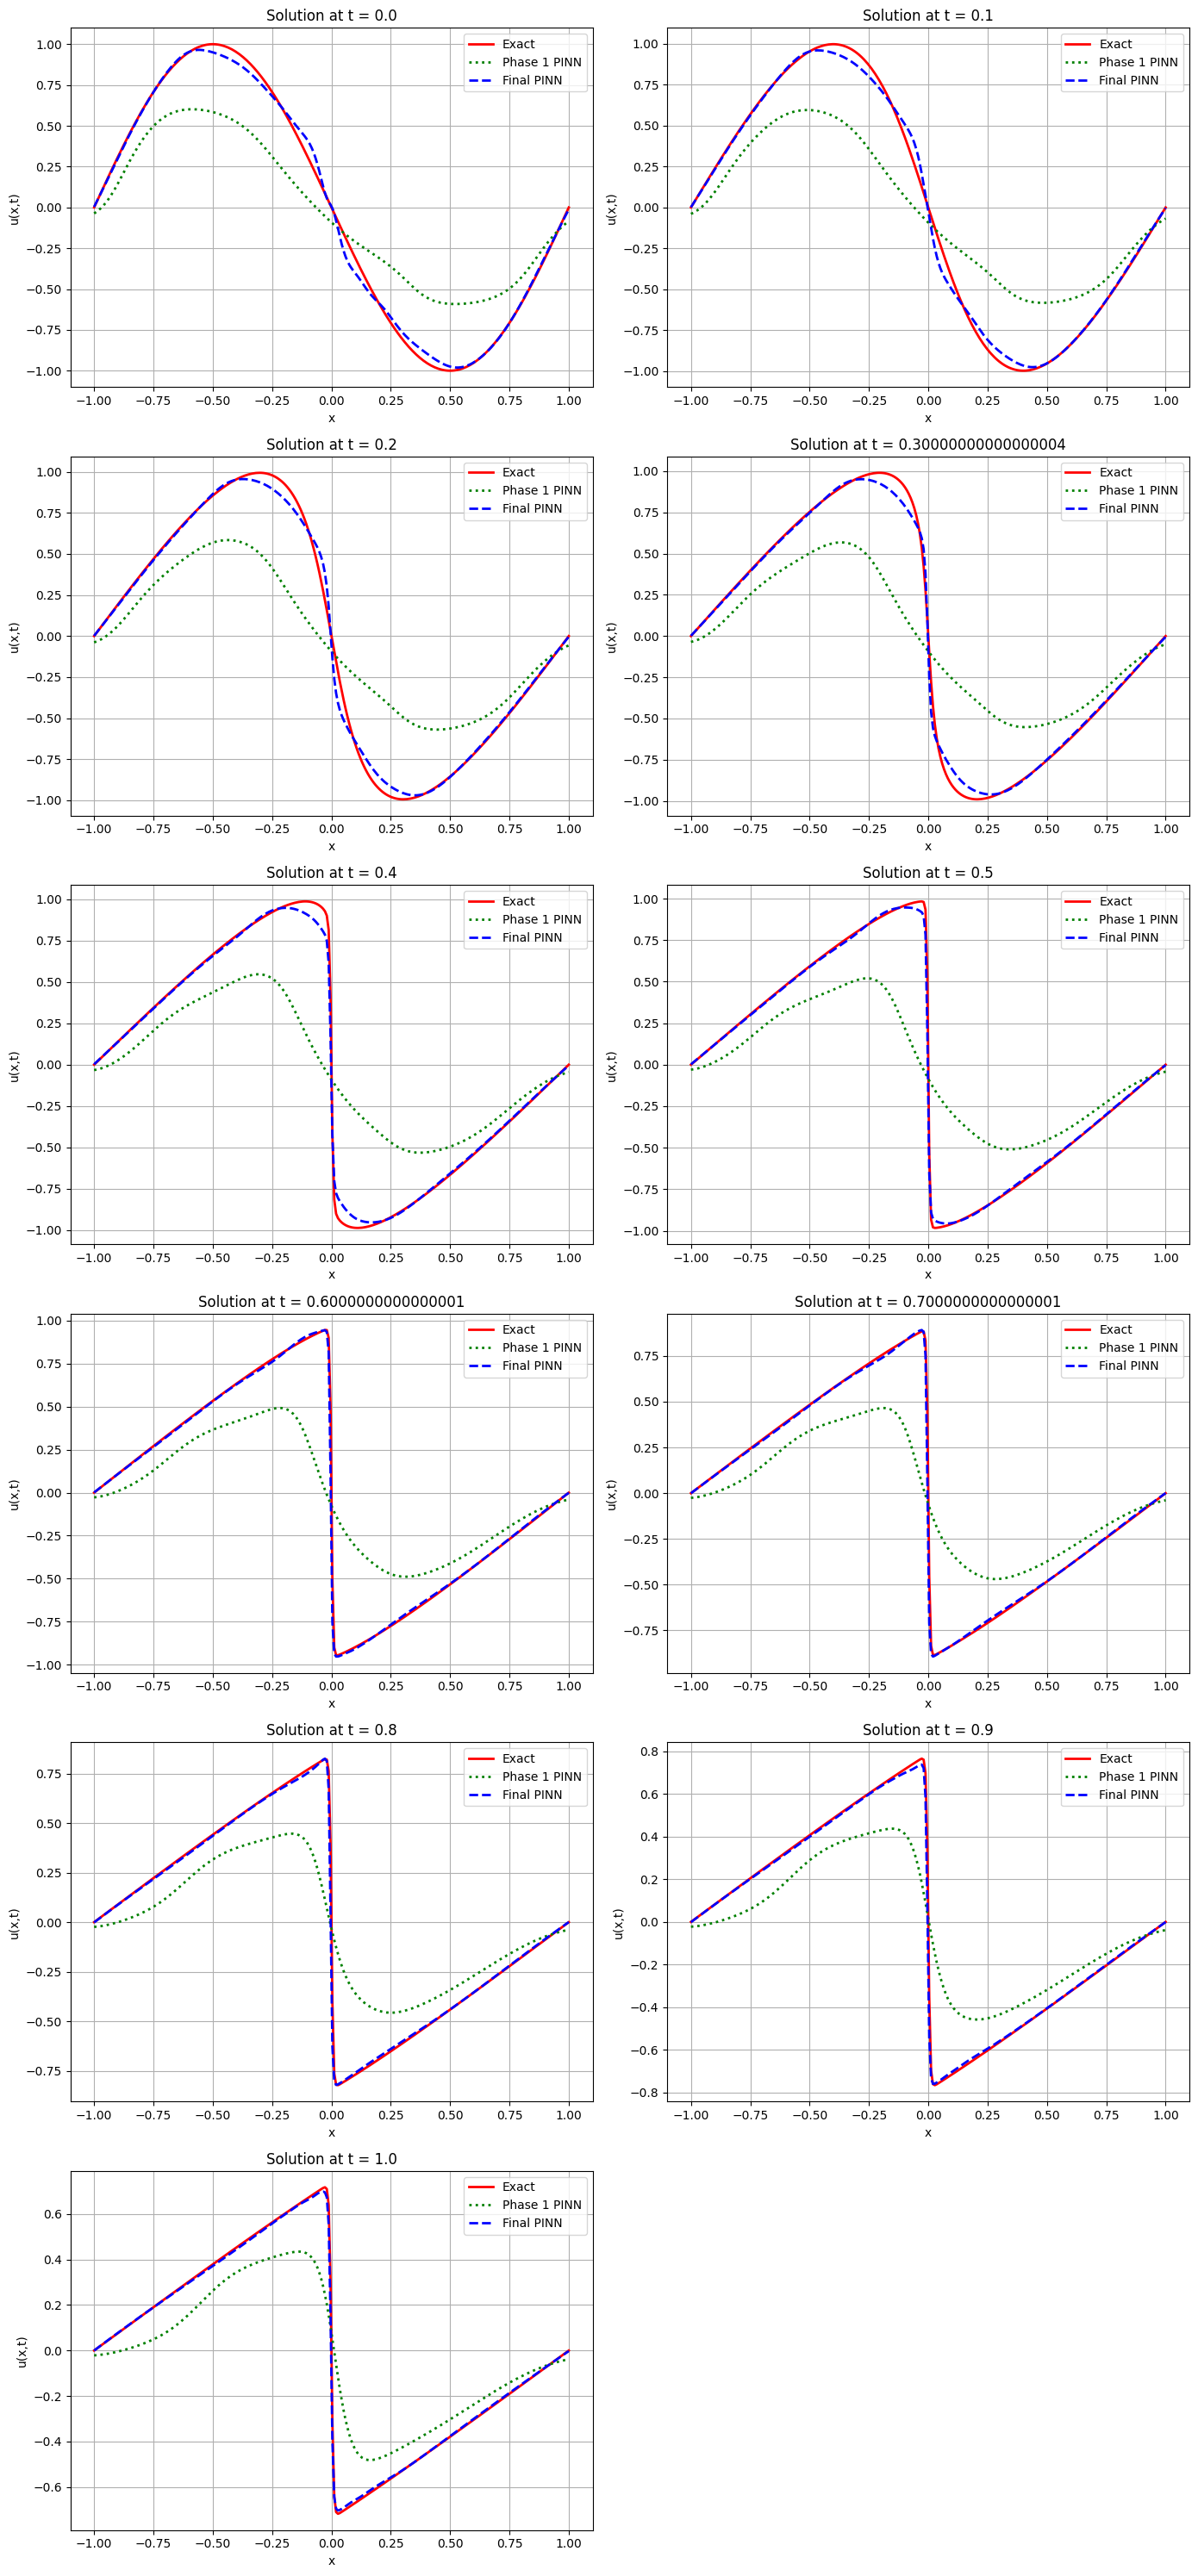

In [82]:
# Define time slices
# time_slices = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
dt = 0.1
num_steps =  int(1.0 / dt) + 1
time_slices = np.linspace(0.0, 1.0, num_steps)
print("time_slices = ", time_slices)
print("num_steps = ", num_steps)

# Reshape predictions
y_pred_phase1_reshaped = y_pred_phase1.reshape(exact.shape)
y_pred_final_reshaped = y_pred_final.reshape(exact.shape)

# x and t grids for slicing
x = x_ref[0, :]
t = t_ref[:, 0]

# Determine subplot layout
num_plots = len(time_slices)
cols = 2
rows = (num_plots + cols - 1) // cols

# Create subplots
fig, axs = plt.subplots(rows, cols, figsize=(14, 5 * rows))
axs = axs.flatten()

# Plot each time slice
for i, t_val in enumerate(time_slices):
    idx = np.argmin(np.abs(t - t_val))

    y_exact = exact[idx, :]
    y_phase1 = y_pred_phase1_reshaped[idx, :]
    y_final = y_pred_final_reshaped[idx, :]

    axs[i].plot(x, y_exact, 'r-', label='Exact', linewidth=2)
    axs[i].plot(x, y_phase1, 'g:', label='Phase 1 PINN', linewidth=2)
    axs[i].plot(x, y_final, 'b--', label='Final PINN', linewidth=2)

    axs[i].set_title(f'Solution at t = {t_val}')
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('u(x,t)')
    axs[i].legend()
    axs[i].grid(True)

# Remove empty axes
for j in range(num_plots, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


In [ ]:
!pip install deepxde

In [84]:
### utilize DeepXDE 
import deepxde as dde
dde.backend.set_default_backend("pytorch")
from deepxde.backend import torch, backend_name
import torch

import numpy as np
import matplotlib.pyplot as plt

'''
"# DeepXDE will internally create tf.keras layers with these specs."
If there is any issue with torch.sin or other torch.###,
just replace it with tf.sin or tf.###.
'''

# # For reproducibility: fix all random seeds used by DeepXDE / TensorFlow backend
# dde.config.set_random_seed(1234)

Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


'\n"# DeepXDE will internally create tf.keras layers with these specs."\nIf there is any issue with torch.sin or other torch.###,\njust replace it with tf.sin or tf.###.\n'

In [89]:
# import torch
# import numpy as np
# import os

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Using device:", device)

# # Load the reference solution data
# dataset_path = "/kaggle/input/pinn-dataset/"
# file_name = "Burgers.npz"

# file_path = os.path.join(dataset_path, file_name)

# data = np.load(file_path)
# t_ref, x_ref, exact = data["t"], data["x"], data["usol"].T

# # Reshape x_ref and t_ref to match the shape of exact
# x_ref, t_ref = np.meshgrid(x_ref, t_ref)

# # Prepare the data
# X_ref = np.vstack((np.ravel(x_ref), np.ravel(t_ref))).T
# Y_ref = exact.flatten()[:, None]

# # Convert to tensor
# X_ref_torch = torch.tensor(X_ref, dtype=torch.float32, device=device)
# Y_ref_torch = torch.tensor(Y_ref, dtype=torch.float32, device=device)

# print("X_ref_torch:", X_ref_torch.shape)
# print("Y_ref_torch:", Y_ref_torch.shape)


Using device: cpu
X_ref_torch: torch.Size([25600, 2])
Y_ref_torch: torch.Size([25600, 1])


In [93]:
# ============================
# 1) Define the PDE residual
# ============================
def pde(x, y):
    """
    PDE residual for a Burgers-type equation:

        u_t + u * u_x - (0.01 / π) * u_xx = 0

    DeepXDE passes:
        x : (N, 2) tensor with columns [x, t]
        y : (N, 1) tensor with network outputs u(x, t)

    We compute:
        dy_t  = ∂u/∂t
        dy_x  = ∂u/∂x
        dy_xx = ∂²u/∂x²

    and return the residual:
        dy_t + u * dy_x - (0.01 / π) * dy_xx
    """
    # First derivative wrt x: ∂u/∂x
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)

    # First derivative wrt t: ∂u/∂t
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)

    # Second derivative wrt x: ∂²u/∂x²
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)

    # PDE residual: u_t + u * u_x - (0.01/π) * u_xx
    return dy_t + y * dy_x - 0.01 / np.pi * dy_xx


# ============================
# 2) Boundary condition helper
# ============================
def is_on_boundary(x, on_boundary):
    """
    Select points that lie on the spatial boundary x = -1 or x = 1.

    DeepXDE calls this with:
        x          : array-like, e.g. [x, t]
        on_boundary: bool, True if the point is on any boundary of the domain

    We further restrict to the spatial boundaries by checking x[0].
    """
    if not on_boundary:
        return False  # Not on any boundary at all

    # Check if the spatial coordinate is at x = -1 or x = 1
    return np.isclose(x[0], -1) or np.isclose(x[0], 1)


def boundary_condition_value(x):
    """
    Dirichlet boundary value at x = -1 and x = 1.

    Here we enforce:
        u(-1, t) = 0
        u(1,  t) = 0
    for all t in [0, 1].

    DeepXDE will call this at boundary points selected by is_on_boundary.
    """
    return 0


# ============================
# 3) Initial condition helper
# ============================
# Alternative version (commented out):
# def is_on_initial_condition(_, on_initial):
#     """
#     Example version that only checks if the point lies on t=0,
#     regardless of the x-coordinate.
#     """
#     return on_initial

def is_on_initial_condition(x, on_initial):
    """
    Select points on the initial time slice t = 0.

    DeepXDE passes:
        x          : array-like [x, t]
        on_initial : bool, True if this point is on the initial-time boundary

    We additionally check that t is numerically close to 0.
    """
    return on_initial and dde.utils.isclose(x[1], 0)


def initial_condition_value(x):
    """
    Initial condition at t = 0:

        u(x, 0) = -sin(π x)

    DeepXDE passes x as a batch of points with shape (N, 2),
    so x[:, 0:1] picks out the spatial coordinate.
    """
    return -np.sin(np.pi * x[:, 0:1])


# ============================
# 4) Geometry and data object
# ============================
# 1D spatial interval x ∈ [-1, 1]
geom = dde.geometry.Interval(-1, 1)

# Time interval t ∈ [0, 1.0]
timedomain = dde.geometry.TimeDomain(0, 1.0)

# Space–time domain: (x, t) ∈ [-1, 1] × [0, 1.0]
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Create boundary and initial condition objects
bc = dde.icbc.DirichletBC(
    geomtime,                # space–time domain
    boundary_condition_value,  # function giving u on boundary
    is_on_boundary           # function selecting boundary points
)

ic = dde.icbc.IC(
    geomtime,                # space–time domain
    initial_condition_value, # function giving u at t=0
    is_on_initial_condition  # function selecting initial-time points
)

# Assemble the TimePDE dataset:
#   - PDE residual in the interior
#   - BC and IC as constraints
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],        # list of boundary/initial conditions
    num_domain=2540, # interior collocation points
    num_boundary=80,# boundary points
    num_initial=160, # initial-condition points
)


# ============================
# 5) External L2 error metric
# ============================
# In the function below, y_pred is effectively a dummy variable.
# DeepXDE will pass in (y_true, y_pred) for each training batch,
# but we ignore both and instead evaluate the model on a fixed
# reference(Exact solution) grid (X_ref, Y_ref).

# First argument `_`  <- y_true for the current batch (ignored)
# Second argument y_pred <- y_pred for the current batch (also ignored)
'''
This function acts as a custom external metric.

- We evaluate the model on a fixed reference grid (X_ref, Y_ref),
  independent of the current training batch.
- Then we compute the L2 relative error between Y_ref
  (reference solution) and the model's prediction on X_ref.

Because we pass this function to `metrics=[...]` inside `model.compile`,
DeepXDE will automatically log this "true generalization metric"
at each logging step, without modifying the internal training loop.
'''
def l2_relative_error_external(_, y_pred):
    # Evaluate the model on the fixed reference grid X_ref
    y_test_pred = model.predict(X_ref)

    # Compute the L2 relative error against the true values Y_ref
    return dde.metrics.l2_relative_error(Y_ref, y_test_pred)


In [94]:
### Training loop (LLM-guided multi-phase optimization)
log, l2_errors = [], []
best_l2_error = 1.0
current_lr, current_epochs = 1e-1, 2000

"""
Notes on what could be tuned across phases:

1) Network architecture
   - Number of layers, width (neurons per layer), activation functions.
   - Example: start with [2, 20, 20, 20, 1], later try [2, 50, 50, 50, 1].

2) Optimizer / training strategy
   - Adam vs. SGD vs. Adam + LBFGS hybrid.
   - Phase-wise strategy, e.g.:
       - Phase 1–2: Adam with larger LR for fast exploration
       - Later phases: Adam with smaller LR or LBFGS for fine-tuning.

3) Sampling-related parameters
   - Number of domain, boundary, and initial points:
       - num_domain, num_boundary, num_initial (for DeepXDE),
       - or analogous sampling sizes in a pure-PyTorch setup.
   - Can increase domain points if PDE residual dominates, or
     increase boundary/IC points if BC/IC are not well enforced.

4) Regularization / stabilization
   - Weight decay (L2 regularization), gradient clipping, noise injection,
     dropout (less common in PINNs but sometimes used).
   - Can help when training is unstable or the loss landscape is noisy.

5) Training schedule
   - Learning-rate scheduling (step decay, cosine annealing, etc.).
   - Phase-wise early stopping, or adjusting the L2 target threshold
     depending on how quickly the error decreases.

6) Physics-based loss terms
   - Add extra terms for energy or mass conservation if available.
   - Reweight boundary / initial / PDE losses:
       e.g., loss_weights = [1, 2, 5, 10] for different loss components.
"""


for phase in range(1, 100):
    print(f"\n🚀 Phase {phase}: LR = {current_lr}, Epochs = {current_epochs}")

    # Re-initialize the network each phase (same architecture, fresh weights)
    net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot uniform")
    model = dde.Model(data, net)

    # DeepXDE assumes metric functions have signature metric(y_true, y_pred).
    # Here we pass a custom metric (e.g., l2_relative_error_external),
    # which internally can evaluate the model on a fixed reference grid (X_ref, Y_ref).
    model.compile("adam", lr=current_lr, metrics=[l2_relative_error_external])

    # Train for the current number of iterations (epochs in DeepXDE semantics).
    history, _ = model.train(iterations=current_epochs)

    # Evaluate on the reference grid for logging / analysis
    y_pred = model.predict(X_ref)

    # Store the prediction from the very first phase for comparison
    if phase == 1:
        y_pred_phase1 = y_pred
    y_pred_final = y_pred  # Last available prediction (from the latest phase)

    # history.loss_train is a list of loss components per iteration.
    # We sum over components to get a scalar loss per iteration.
    loss_list = [sum(l) for l in history.loss_train]
    final_loss = loss_list[-1]

    # L2 relative error against the reference solution Y_ref (or Y_ref)
    l2_error = dde.metrics.l2_relative_error(Y_ref, y_pred)
    best_l2_error = min(best_l2_error, l2_error)
    l2_errors.append(l2_error)

    # Logging for later inspection / plotting
    log.append({
        "Phase": phase,
        "LR": f"{current_lr:.0e}",
        "Epochs": current_epochs,
        "Final Loss": final_loss,
        "L2 Rel Error": l2_error,
    })

    print(f"📉 L2 Error: {l2_error:.2e}")
    if l2_error < 0.035:
        print(f"✅ Early stopping at phase {phase}")
        break

    # Ask the LLM for the next phase's hyperparameters (learning rate, epochs)
    current_lr, current_epochs = query_llm_for_hyperparams(
        current_lr, loss_list, current_epochs, l2_error, l2_errors, best_l2_error, phase
    )



🚀 Phase 1: LR = 0.1, Epochs = 2000
Compiling model...
'compile' took 0.008687 s

Training model...

0         [8.45e-02, 2.57e-01, 2.33e-01]    [8.45e-02, 2.57e-01, 2.33e-01]    [8.41e-01]    
1000      [6.52e-02, 5.75e-03, 4.03e-02]    [6.52e-02, 5.75e-03, 4.03e-02]    [3.86e-01]    
2000      [2.90e-02, 1.59e-03, 3.44e-02]    [2.90e-02, 1.59e-03, 3.44e-02]    [3.55e-01]    

Best model at step 2000:
  train loss: 6.50e-02
  test loss: 6.50e-02
  test metric: [3.55e-01]

'train' took 17.742303 s

📉 L2 Error: 3.55e-01

🚀 Phase 2: LR = 0.01, Epochs = 4000
Compiling model...
'compile' took 0.003801 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [8.45e-02, 2.57e-01, 2.33e-01]    [8.45e-02, 2.57e-01, 2.33e-01]    [8.41e-01]    
1000      [2.83e-02, 1.43e-04, 3.98e-02]    [2.83e-02, 1.43e-04, 3.98e-02]    [3.70e-01]    
2000      [9.73e-03, 9.34e-05, 1.24e-02]    [9.73e-03, 9.34e-05, 1.24e-02]    [3.59e-01]    
3

KeyboardInterrupt: 